# Investigation on Traffic Crashes in Chicago


# Table of Contents
1. [Abstract](#abstract)
2. [Data Source](#data-source)
3. [Exploratory Data Analysis](#exploratory-data-analysis)  
    3.1 [Traffic Crashes](#traffic-crashes)  
    3.2 [Traffic Segments](#traffic-segments)  
    3.3 [Population Density](#population-density)  
    3.4 [Solar Position](#solar-position)  
    3.5 [Weather](#weather)
4. [Modeling](#modeling)
5. [Conclusion](#conclusion)

<a id='abstract'></a>
# 1. Abstract

Traffic crash is not only an major topic in Geographic AI, but also directly ralated to people's daily life. Nearly 1.3 million people die internationally every year from car accidents and in addition up to 50 million people are injured. Machine learning can be a helpful tool to analyze and reduce the risk of crashes. In this work, an data analysis is demonstrated on Chicago traffic crashes (20016-2018), followed by a prediction of risk and severity of crashes based on random forrest model. This work is a promising application for safe route planning, emergency vehicle allocation, roadway design and where to place additional traffic control devices.

<a id='data-source'></a>
# 2. Data Source
Traffic crash data can be obtained at [Chicago Data Portal](https://data.cityofchicago.org/), using SODA API or exporting directly from the website. The links and descriptions of datasets are listed below:
1. [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if): Major dataset for this project. Related datesets [Traffic Crashes - Vehicles](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3), [Traffic Crashes - People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d).
2. [Road Segments in Chicago](https://data.cityofchicago.org/dataset/transportation/pr57-gg9e): Geo-information of traffic segments in Chicago, can also be [viewed in map](https://data.cityofchicago.org/Transportation/Street-Center-Lines/6imu-meau).
3. [Population by Census Blocks](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Population-by-2010-Census-Block/5yjb-v3mj) and [Boundaries of Census Tracts](https://data.cityofchicago.org/dataset/CensusTractsTIGER2010/74p9-q2aq): The total population and area for each census tracts in 2010.


<a id='exploratory-data-analysis'></a>
# 3. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns

pd.set_option('display.max_columns', 100)

<a id='traffic-crashes'></a>
### 3.1 Traffic Crashes
Load dataset [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) using SODA API.

In [3]:
from sodapy import Socrata

end_point = 'data.cityofchicago.org'
app_token = 'IaMIsAtmEfVIRb6i2lfqYvVmz'
max_rows = 300000

client = Socrata(end_point, app_token)
crash_raw = client.get("85ca-t3if", limit=max_rows)
crash_raw = pd.DataFrame(crash_raw)
crash_raw.shape

(300000, 48)

Setting data types and have a glance.

In [4]:
# formatting float columns
cols_float = ['posted_speed_limit', 'lane_cnt', 'beat_of_occurrence', 'num_units', 
              'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 
              'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown', 
              'latitude', 'longitude'
             ]
# formatting datatime columns
for col in cols_float:
    crash_raw[col] = crash_raw[col].astype(float)
    
cols_int = ['street_no', 'crash_hour', 'crash_day_of_week', 'crash_month']
for col in cols_int:
    crash_raw[col] = crash_raw[col].astype(int)



crash_raw['crash_date'] = pd.to_datetime(crash_raw['crash_date'])
crash_raw['date_police_notified'] = pd.to_datetime(crash_raw['date_police_notified'])

# formatting column names to upper case
crash_raw.columns = map(str.upper, crash_raw.columns)

In [5]:
crash_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297426 entries, 0 to 297425
Data columns (total 48 columns):
ALIGNMENT                        297426 non-null object
BEAT_OF_OCCURRENCE               297422 non-null float64
CRASH_DATE                       297426 non-null datetime64[ns]
CRASH_DATE_EST_I                 22255 non-null object
CRASH_DAY_OF_WEEK                297426 non-null int32
CRASH_HOUR                       297426 non-null int32
CRASH_MONTH                      297426 non-null int32
CRASH_TYPE                       297426 non-null object
DAMAGE                           297426 non-null object
DATE_POLICE_NOTIFIED             297426 non-null datetime64[ns]
DEVICE_CONDITION                 297426 non-null object
DOORING_I                        968 non-null object
FIRST_CRASH_TYPE                 297426 non-null object
HIT_AND_RUN_I                    82204 non-null object
INJURIES_FATAL                   296167 non-null float64
INJURIES_INCAPACITATING          296167

Select crashes in 2017-2018

In [6]:
crash = crash_raw[(crash_raw['CRASH_DATE'] < pd.datetime(2019,1,1)) & (crash_raw['CRASH_DATE'] >= pd.datetime(2017,1,1))].copy()

Deal with outliers and missing values in geo coordinates(LATITUDE, LONGITUDE), INJURIES_FATAL and POSTED_SPEED_LIMIT, then convert dataframe to geo dataframe.

In [7]:
crash = crash[crash['LOCATION'].notnull()]
#crash.boxplot(column=['LONGITUDE', 'LATITUDE'])
# drop rows with outliers in LATITUDE and LONGITUDE (outlier defiend as being out of 10 std range)
crash = crash[np.abs(crash['LATITUDE'] - crash['LATITUDE'].mean()) <= (10 * crash['LATITUDE'].std())]
crash = crash[np.abs(crash['LONGITUDE'] - crash['LONGITUDE'].mean()) <= (10 * crash['LONGITUDE'].std())]

crash = crash[crash['INJURIES_FATAL'].notnull()]
crash = crash[crash['MOST_SEVERE_INJURY'].notnull()]

crash = crash[(crash['POSTED_SPEED_LIMIT'] > 0) & (crash['POSTED_SPEED_LIMIT'] % 5 == 0) ]
# convert datagframe to geo-dataframe
crash['LOCATION'] = crash['LOCATION'].apply(shape)
crs = {'init': 'epsg:4326'} #Coordinate Reference Systems (crs): WGS84 Latitude/Longitude
crash = gpd.GeoDataFrame(crash, geometry='LOCATION', crs=crs)

crash.shape

(196571, 48)

Export the crash data as a shapefile for future use in ArcGIS.

In [8]:
'''
test = crash.copy()
test['CRASH_DATE'] = test['CRASH_DATE'].astype(str)
test['DATE_POLICE_NOTIFIED'] = test['DATE_POLICE_NOTIFIED'].astype(str)
test.to_file("crash.shp")
'''

'\ntest = crash.copy()\ntest[\'CRASH_DATE\'] = test[\'CRASH_DATE\'].astype(str)\ntest[\'DATE_POLICE_NOTIFIED\'] = test[\'DATE_POLICE_NOTIFIED\'].astype(str)\ntest.to_file("crash.shp")\n'

road segment data columns:
road id
AADT
SURF_TYP   :   Item 18 - Surface Type 
    SURF_WTH   :   Item 20 - Surface Width 
SEG_LENGTH   :   Item 7A - Length 
    Shape_Leng   :   GIS added length field
    ROAD_NAME
    
    

<a id='traffic-segments'></a>
### 3.2 Traffic Segments
Adding [road segment data](https://data.cityofchicago.org/dataset/transportation/pr57-gg9e) into crash records.

In [4]:
road_raw = client.get("pr57-gg9e", limit=max_rows)

road_raw = pd.DataFrame(road_raw)
road_raw['the_geom'] = road_raw['the_geom'].apply(shape)

crs = {'init': 'epsg:4326'} #Coordinate Reference Systems (crs): WGS84 Latitude/Longitude
road_raw = gpd.GeoDataFrame(road_raw, geometry='the_geom', crs=crs)
road_raw.shape

(56338, 50)

In [5]:
road_raw.tail()

,class,create_tim,create_use,dir_travel,edit_date,edit_type,ewns,ewns_coord,ewns_dir,f_cross,f_cross_st,f_zlev,flag_strin,fnode_id,l_censusbl,l_f_add,l_fips,l_parity,l_t_add,l_zip,length,logiclf,logiclt,logicrf,logicrt,objectid,oneway_dir,pre_dir,r_censusbl,r_f_add,r_fips,r_parity,r_t_add,r_zip,shape_len,status,status_dat,street_nam,street_typ,streetname,suf_dir,t_cross,t_cross_st,t_zlev,the_geom,tiered,tnode_id,trans_id,update_tim,update_use
56333,3,2016-06-02T00:00:00.000Z,ds06027,T,20160602,Split Street,0,0,NaN,13000|S|SAGINAW|AVE|,1695,0,NaN,37993,170315502002005,13023,14000,O,13033,60633,267.65845047,13023,13033,13032,13046,71044,NaN,S,170315502002006,13032,14000,E,13046,60633,267.658450471,N,1999-01-01T00:00:00.000Z,BRAINARD,AVE,1159,NaN,2722|E|131ST|ST|,59,0,(LINESTRING (-87.55784956501411 41.65791820995...,N,610,164905,2016-06-02T00:00:00.000Z,ds06027
56334,3,2016-01-20T00:00:00.000Z,ds06027,B,20160120,Cross Street Change,0,0,NaN,3717|N|||,0,0,NaN,37989,170311611002010,3718,14000,E,3742,60641,291.84592593,3718,3742,3719,3741,70722,NaN,N,170311611002003,3719,14000,O,3741,60641,291.845925929,N,1999-01-01T00:00:00.000Z,MILWAUKEE,AVE,845,NaN,3701|N|KENNETH|AVE|,649,0,(LINESTRING (-87.73902939370839 41.94834404748...,N,8439,164895,2016-01-20T00:00:00.000Z,ds06027
56335,4,2016-01-20T00:00:00.000Z,ds06027,T,20160120,Cross Street Change,-4432,4432,W,0||||,0,0,NaN,37990,170311611002010,3630,14000,E,3664,60641,464.26250341,3630,3698,3631,3699,70723,NaN,N,170311611002010,3631,14000,O,3665,60641,464.262503411,NaN,2016-01-20T00:00:00.000Z,KENNETH,AVE,649,NaN,3718|N|MILWAUKEE|AVE|,845,0,(LINESTRING (-87.73879459600205 41.94718195189...,N,37989,164896,2016-01-21T00:00:00.000Z,ds06027
56336,4,1999-01-01T00:00:00.000Z,EXISTING,T,20150825,Address Change,600,600,N,600|N|KILPATRICK|AVE|,664,0,NaN,33563,170312517002000,4701,14000,O,4759,60644,622.70802865,4701,4799,4700,4798,19741,E,W,170312517003007,4700,14000,E,4752,60644,622.707971443,N,1999-01-01T00:00:00.000Z,OHIO,ST,2452,NaN,600|N|CICERO|AVE|,428,0,(LINESTRING (-87.74339277679763 41.89141500093...,N,16755,121056,2015-08-25T00:00:00.000Z,ds06027
56337,E,2016-01-25T00:00:00.000Z,ds06027,T,20160127,New Segment,-2200,2200,W,2199|W|HASTINGS|ST|,2280,0,NaN,24059,170312842001006,1329,14000,O,1349,60608,94.53859333,1329,1349,1332,1350,71042,NaN,S,170312842001005,1332,14000,E,1350,60608,94.5385933332,NaN,2016-01-25T00:00:00.000Z,LEAVITT,ST,1527,NaN,||DEAD END||,0,0,(LINESTRING (-87.68107407701358 41.86396934639...,N,37992,164902,2016-01-27T00:00:00.000Z,ds06027


In [11]:
road_raw.columns

Index(['class', 'create_tim', 'create_use', 'dir_travel', 'edit_date',
       'edit_type', 'ewns', 'ewns_coord', 'ewns_dir', 'f_cross', 'f_cross_st',
       'f_zlev', 'flag_strin', 'fnode_id', 'l_censusbl', 'l_f_add', 'l_fips',
       'l_parity', 'l_t_add', 'l_zip', 'length', 'logiclf', 'logiclt',
       'logicrf', 'logicrt', 'objectid', 'oneway_dir', 'pre_dir', 'r_censusbl',
       'r_f_add', 'r_fips', 'r_parity', 'r_t_add', 'r_zip', 'shape_len',
       'status', 'status_dat', 'street_nam', 'street_typ', 'streetname',
       'suf_dir', 't_cross', 't_cross_st', 't_zlev', 'the_geom', 'tiered',
       'tnode_id', 'trans_id', 'update_tim', 'update_use'],
      dtype='object')

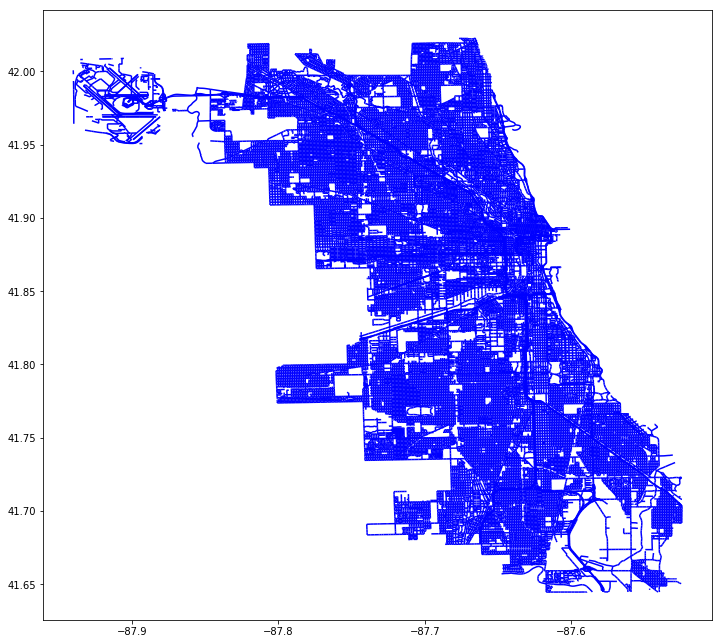

In [12]:
road_raw.plot(markersize=0.01, edgecolor='blue',figsize=(12,12))

In [13]:
selected_columns_road = ['objectid', 'class', 'pre_dir', 'street_nam', 'street_typ',
                         'suf_dir', 'dir_travel', 'length',
                         'logiclf', 'logiclt', 'logicrf', 'logicrt',
                         'the_geom'
                        ]

road = road_raw[selected_columns_road]

road = road[road['street_nam'].notnull()]

int_columns = ['logiclf', 'logiclt', 'logicrf', 'logicrt']
for col in int_columns:
    road[col] = road[col].astype(int)

Join road segment information to crashes

In [14]:
import time
start_time = time.time()

radius = 0.0002 # degree
crash['BUFFER'] = crash.geometry.buffer(radius)
crash.set_geometry('BUFFER', inplace=True)


crash_joined = gpd.sjoin(crash, road, how="inner", op='intersects')

str_typ_list = list(road['street_typ'].value_counts().keys())
str_suffix_list = list(road['suf_dir'].value_counts().keys())

def check_str_nam(row):
    
    if row['STREET_DIRECTION'] != row['pre_dir']:
        return False
    
    if row['street_nam'] not in row['STREET_NAME']:
        return False
    
    end_word = row['STREET_NAME'].split(' ')[-1]
    left_word = row['STREET_NAME'][:-len(end_word)-1]
    str_nam_road = row['street_nam']
    suf_road = row['suf_dir']
    
    # Deal with the exceptions in road names
    # 1. INCOLN PARK WEST is actually INCOLN PARK W
    if end_word == 'WEST':
        end_word = 'W'
    # 2. Road names contain "LOWER" are in reversed order in road and crash dataframes
    if row['STREET_NAME'].split(' ')[0] == 'LOWER':
        left_word = row['STREET_NAME'][len('LOWER')+1:-len(end_word)-1]
    if row['street_nam'].split(' ')[-1] == 'LOWER':
        str_nam_road = row['street_nam'][:-len('LOWER')-1]
    # 3. LAKE SHORE DR: do not take suf_dir into consideration
    #if left_word == 'LAKE SHORE DR':
    #   end_word = left_word.split(' ')[-1]
    #   left_word = left_word[:-len(end_word)-1]
    #   suf_road = np.nan
    
    crash_got_suf = end_word in str_suffix_list
    road_got_suf = pd.notnull(suf_road)
    
    if end_word in str_suffix_list:
        
        suf = end_word
        if crash_got_suf and road_got_suf:
            return suf == suf_road
        elif crash_got_suf and (not road_got_suf):
            return False
        elif (not crash_got_suf) and road_got_suf:
            return False
        else:
            return True
        
    elif end_word in str_typ_list:
        
        if road_got_suf:
            return False
        
        str_typ = end_word
        str_nam_crash = left_word
        # end_word is a type word. It does not gurantee the road type. For exmaple:
        # 
        if str_nam_crash != str_nam_road:
            return False
        elif str_typ != row['street_typ']:
            return False
        else:
            return True
    else:
        return row['street_nam'] == row['STREET_NAME']
    
    
str_nam = crash_joined.apply(lambda row: check_str_nam(row), axis=1)


def check_str_no(row):
    flag = row['STREET_NO'] % 2
    
    if row['logiclt'] != 0:
        flag1 = row['logiclt'] % 2
    else:
        flag1 = -1
        
    if row['logicrt'] != 0:
        flag2 = row['logicrt'] % 2
    else:
        flag2 = -1
    
    if flag == flag1:
        return row['STREET_NO'] in range(row['logiclf'], row['logiclt']+1)
    elif flag == flag2:
        return row['STREET_NO'] in range(row['logicrf'], row['logicrt']+1)
    else:
        return False

str_no = crash_joined.apply(lambda row: check_str_no(row), axis=1)

end_time = time.time()
print("Time Spent", end_time - start_time)

crash_joined = crash_joined[str_no & str_nam]
crash_joined = crash_joined.set_geometry('LOCATION')
crash_joined.rename(columns = {'index_right':'road_seg_id'}, inplace=True)

Time Spent 199.22856163978577


,ALIGNMENT,BEAT_OF_OCCURRENCE,CRASH_DATE,CRASH_DATE_EST_I,CRASH_DAY_OF_WEEK,CRASH_HOUR,CRASH_MONTH,CRASH_TYPE,DAMAGE,DATE_POLICE_NOTIFIED,DEVICE_CONDITION,DOORING_I,FIRST_CRASH_TYPE,HIT_AND_RUN_I,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NO_INDICATION,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_TOTAL,INJURIES_UNKNOWN,INTERSECTION_RELATED_I,LANE_CNT,LATITUDE,LIGHTING_CONDITION,LOCATION,LONGITUDE,MOST_SEVERE_INJURY,NUM_UNITS,PHOTOS_TAKEN_I,POSTED_SPEED_LIMIT,PRIM_CONTRIBUTORY_CAUSE,PRIVATE_PROPERTY_I,RD_NO,REPORT_TYPE,ROAD_DEFECT,ROADWAY_SURFACE_COND,SEC_CONTRIBUTORY_CAUSE,STATEMENTS_TAKEN_I,STREET_DIRECTION,STREET_NAME,STREET_NO,TRAFFIC_CONTROL_DEVICE,TRAFFICWAY_TYPE,WEATHER_CONDITION,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,BUFFER,index_right,objectid,class,pre_dir,street_nam,street_typ,suf_dir,dir_travel,length,logiclf,logiclt,logicrf,logicrt
46146,STRAIGHT AND LEVEL,1123.0,2018-12-15 17:38:00,NaN,7,17,12,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-12-15 17:45:00,NO CONTROLS,NaN,OTHER OBJECT,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N,2.0,41.884330,"DARKNESS, LIGHTED ROAD",POINT (-87.71096101127701 41.884330137309),-87.710961,NO INDICATION OF INJURY,1.0,NaN,30.0,NOT APPLICABLE,NaN,JB554807,ON SCENE,NO DEFECTS,WET,NOT APPLICABLE,NaN,N,HOMAN BLVD,151,NO CONTROLS,NOT DIVIDED,CLOUDY/OVERCAST,NaN,NaN,NaN,"POLYGON ((-87.710761011277 41.884330137309, -8...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199
81216,STRAIGHT AND LEVEL,1123.0,2018-08-30 16:00:00,NaN,5,16,8,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-08-30 23:20:00,NO CONTROLS,NaN,REAR END,N,0.0,0.0,1.0,1.0,0.0,1.0,0.0,N,NaN,41.883752,DUSK,POINT (-87.71123675036399 41.883752492501),-87.711237,NONINCAPACITATING INJURY,2.0,NaN,30.0,EXCEEDING AUTHORIZED SPEED LIMIT,NaN,JB415836,ON SCENE,UNKNOWN,UNKNOWN,UNABLE TO DETERMINE,NaN,N,HOMAN BLVD,134,NO CONTROLS,DIVIDED - W/MEDIAN (NOT RAISED),CLEAR,NaN,NaN,NaN,"POLYGON ((-87.71103675036399 41.883752492501, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199
85485,STRAIGHT AND LEVEL,1123.0,2018-08-17 09:55:00,NaN,6,9,8,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-08-17 10:14:00,NO CONTROLS,NaN,REAR END,NaN,0.0,0.0,1.0,0.0,2.0,2.0,0.0,NaN,4.0,41.883876,DAYLIGHT,POINT (-87.710945892113 41.883876221116),-87.710946,"REPORTED, NOT EVIDENT",2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB397115,ON SCENE,NO DEFECTS,DRY,NOT APPLICABLE,NaN,N,HOMAN BLVD,137,NO CONTROLS,NOT DIVIDED,CLEAR,NaN,NaN,NaN,"POLYGON ((-87.710745892113 41.883876221116, -8...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199
95408,STRAIGHT AND LEVEL,1123.0,2018-07-17 16:30:00,NaN,3,16,7,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-07-17 16:36:00,FUNCTIONING PROPERLY,NaN,REAR END,NaN,0.0,0.0,2.0,0.0,3.0,3.0,0.0,Y,2.0,41.884583,DAYLIGHT,POINT (-87.710971491762 41.884583471681),-87.710971,"REPORTED, NOT EVIDENT",2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB353781,ON SCENE,NO DEFECTS,DRY,UNABLE TO DETERMINE,NaN,N,HOMAN BLVD,163,TRAFFIC SIGNAL,NOT DIVIDED,CLEAR,NaN,NaN,NaN,"POLYGON ((-87.71077149176199 41.884583471681, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199
104089,STRAIGHT AND LEVEL,1123.0,2018-06-22 10:15:00,NaN,6,10,6,NO INJURY / DRIVE AWAY,$500 OR LESS,2018-06-22 11:35:00,NO CONTROLS,NaN,REAR END,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,2.0,41.884583,DAYLIGHT,POINT (-87.710971491762 41.884583471681),-87.710971,NO INDICATION OF INJURY,2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB317673,NOT ON SCENE (DESK REPORT),NO DEFECTS,WET,IMPROPER LANE USAGE,NaN,N,HOMAN BLVD,159,NO CONTROLS,NOT DIVIDED,RAIN,NaN,NaN,NaN,"POLYGON ((-87.71077149176199 41.884583471681, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199
189586,STRAIGHT AND LEVEL,1123.0,2017-09-29 14:34:00,NaN,6,14,9,NO INJURY / DRIVE AWAY,$500 OR LESS,2017-09-29 14:39:00,UNKNOWN,NaN,FIXED OBJECT,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,2.0,41.884583,DAYLIGHT,POINT (-87.710971491762 41.884583471681),-87.710971,NO INDICATION 

In [15]:
# Make sure that every crash is related to only one raod segment
#crash_joined.RD_NO.value_counts()

# Check how many crash records are excluded
#left = crash[~crash.index.isin(crash_joined.index)]
#left.STREET_NAME.value_counts()


<a id='population-density'></a>
### 3.3 Population Density

Use [total population by Census Block](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Population-by-2010-Census-Block/5yjb-v3mj) and [Boundaries of Census Tracts](https://data.cityofchicago.org/dataset/CensusTractsTIGER2010/74p9-q2aq) ([map view](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik)) to calculate population density.  

First, load total population dataset.

In [6]:
pop_total = client.get("5yjb-v3mj", limit=max_rows)
pop_total = pd.DataFrame(pop_total)
pop_area = client.get("74p9-q2aq", limit=max_rows)
pop_area = pd.DataFrame(pop_area)

In [9]:
pop_total.tail()

,census_block,census_block_full,total_population
46286,9801001006,170319801001006,0
46287,9801001007,170319801001007,0
46288,9801001008,170319801001008,0
46289,9801001009,170319801001009,0
46290,9801001010,170319801001010,0


In [10]:
pop_area.tail()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,the_geom,tractce10
796,7,7,031,17031070400,704,Census Tract 704,,17,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",070400
797,7,7,031,17031070500,705,Census Tract 705,,17,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",070500
798,13,13,031,17031130300,1303,Census Tract 1303,,17,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",130300
799,29,29,031,17031292200,2922,Census Tract 2922,,17,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",292200
800,63,63,031,17031630900,6309,Census Tract 6309,,17,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",630900


In [32]:
pop_total.total_population = pop_total.total_population.astype(int)
pop_total['tract'] = pop_total.apply(lambda x: x['census_block'][:6], axis=1)
pop_total_tract = pop_total.groupby('tract').sum()['total_population']

In [49]:
pop_area['the_geom'] = pop_area['the_geom'].apply(shape)

crs = {'init': 'epsg:4326'} #Coordinate Reference Systems (crs): WGS84 Latitude/Longitude
pop_area = gpd.GeoDataFrame(pop_area, geometry='the_geom', crs=crs)
pop_area['area'] = pop_area.geometry.apply(lambda x: x.area)
pop_area

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,the_geom,tractce10,area
0,44,44,031,17031842400,8424,Census Tract 8424,,17,(POLYGON ((-87.62404799998049 41.7302169999839...,842400,0.000213
1,59,59,031,17031840300,8403,Census Tract 8403,,17,(POLYGON ((-87.6860799999848 41.82295600001154...,840300,0.000090
2,34,34,031,17031841100,8411,Census Tract 8411,,17,(POLYGON ((-87.62934700001182 41.8527970000265...,841100,0.000124
3,31,31,031,17031841200,8412,Census Tract 8412,,17,(POLYGON ((-87.68813499997718 41.8556909999909...,841200,0.000068
4,32,32,031,17031839000,8390,Census Tract 8390,,17,(POLYGON ((-87.63312200003458 41.8744880000269...,839000,0.000056
5,28,28,031,17031838200,8382,Census Tract 8382,,17,(POLYGON ((-87.66781999997529 41.8741839999791...,838200,0.000126
6,65,65,031,17031650301,6503.01,Census Tract 6503.01,,17,(POLYGON ((-87.73706400002477 41.7712039999837...,650301,0.000107
7,53,53,031,17031530503,5305.03,Census Tract 5305.03,,17,(POLYGON ((-87.64386399998179 41.6632100000208...,530503,0.000177
8,76,76,031,17031760803,7608.03,Census Tract 7608.03,,17,(POLYGON ((-87.83844200004106 41.9701999999708...,760803,0.000083
9,77,77,031,17031030601,306.01,Census Tract 306.01,,17,(POLYGON ((-87.6543830000042 41.99020200000391...,030601,0.000027


In [55]:
pop_joined = pd.concat([pop_total_tract,pop_area.set_index('tractce10')], axis=1, join='inner')
pop_joined['pop_density'] = pop_joined['total_population'] / pop_joined['area']
pop_joined = pop_joined.set_geometry('the_geom')
pop_joined.drop(pop_joined.sort_values('pop_density').tail(1).index).plot(column='pop_density', markersize=0.01,figsize=(20,20),legend=True)

In [85]:

crash_joined_1 = gpd.sjoin(crash_joined, pop_joined[['the_geom', 'pop_density']], how="inner", op='intersects')
crash_joined_1
#crash_joined = gpd.sjoin(crash, road, how="inner", op='intersects')

C:\Users\sheng\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,ALIGNMENT,BEAT_OF_OCCURRENCE,CRASH_DATE,CRASH_DATE_EST_I,CRASH_DAY_OF_WEEK,CRASH_HOUR,CRASH_MONTH,CRASH_TYPE,DAMAGE,DATE_POLICE_NOTIFIED,DEVICE_CONDITION,DOORING_I,FIRST_CRASH_TYPE,HIT_AND_RUN_I,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NO_INDICATION,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_TOTAL,INJURIES_UNKNOWN,INTERSECTION_RELATED_I,LANE_CNT,LATITUDE,LIGHTING_CONDITION,LOCATION,LONGITUDE,MOST_SEVERE_INJURY,NUM_UNITS,PHOTOS_TAKEN_I,POSTED_SPEED_LIMIT,PRIM_CONTRIBUTORY_CAUSE,PRIVATE_PROPERTY_I,RD_NO,REPORT_TYPE,ROAD_DEFECT,ROADWAY_SURFACE_COND,SEC_CONTRIBUTORY_CAUSE,STATEMENTS_TAKEN_I,STREET_DIRECTION,STREET_NAME,STREET_NO,TRAFFIC_CONTROL_DEVICE,TRAFFICWAY_TYPE,WEATHER_CONDITION,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,BUFFER,road_seg_id,objectid,class,pre_dir,street_nam,street_typ,suf_dir,dir_travel,length,logiclf,logiclt,logicrf,logicrt,index_right,pop_density
46146,STRAIGHT AND LEVEL,1123.0,2018-12-15 17:38:00,NaN,7,17,12,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-12-15 17:45:00,NO CONTROLS,NaN,OTHER OBJECT,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N,2.0,41.884330,"DARKNESS, LIGHTED ROAD",POINT (-87.71096101127701 41.884330137309),-87.710961,NO INDICATION OF INJURY,1.0,NaN,30.0,NOT APPLICABLE,NaN,JB554807,ON SCENE,NO DEFECTS,WET,NOT APPLICABLE,NaN,N,HOMAN BLVD,151,NO CONTROLS,NOT DIVIDED,CLOUDY/OVERCAST,NaN,NaN,NaN,"POLYGON ((-87.710761011277 41.884330137309, -8...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199,836800,3.006240e+07
81216,STRAIGHT AND LEVEL,1123.0,2018-08-30 16:00:00,NaN,5,16,8,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-08-30 23:20:00,NO CONTROLS,NaN,REAR END,N,0.0,0.0,1.0,1.0,0.0,1.0,0.0,N,NaN,41.883752,DUSK,POINT (-87.71123675036399 41.883752492501),-87.711237,NONINCAPACITATING INJURY,2.0,NaN,30.0,EXCEEDING AUTHORIZED SPEED LIMIT,NaN,JB415836,ON SCENE,UNKNOWN,UNKNOWN,UNABLE TO DETERMINE,NaN,N,HOMAN BLVD,134,NO CONTROLS,DIVIDED - W/MEDIAN (NOT RAISED),CLEAR,NaN,NaN,NaN,"POLYGON ((-87.71103675036399 41.883752492501, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199,836800,3.006240e+07
85485,STRAIGHT AND LEVEL,1123.0,2018-08-17 09:55:00,NaN,6,9,8,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-08-17 10:14:00,NO CONTROLS,NaN,REAR END,NaN,0.0,0.0,1.0,0.0,2.0,2.0,0.0,NaN,4.0,41.883876,DAYLIGHT,POINT (-87.710945892113 41.883876221116),-87.710946,"REPORTED, NOT EVIDENT",2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB397115,ON SCENE,NO DEFECTS,DRY,NOT APPLICABLE,NaN,N,HOMAN BLVD,137,NO CONTROLS,NOT DIVIDED,CLEAR,NaN,NaN,NaN,"POLYGON ((-87.710745892113 41.883876221116, -8...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199,836800,3.006240e+07
95408,STRAIGHT AND LEVEL,1123.0,2018-07-17 16:30:00,NaN,3,16,7,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2018-07-17 16:36:00,FUNCTIONING PROPERLY,NaN,REAR END,NaN,0.0,0.0,2.0,0.0,3.0,3.0,0.0,Y,2.0,41.884583,DAYLIGHT,POINT (-87.710971491762 41.884583471681),-87.710971,"REPORTED, NOT EVIDENT",2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB353781,ON SCENE,NO DEFECTS,DRY,UNABLE TO DETERMINE,NaN,N,HOMAN BLVD,163,TRAFFIC SIGNAL,NOT DIVIDED,CLEAR,NaN,NaN,NaN,"POLYGON ((-87.71077149176199 41.884583471681, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199,836800,3.006240e+07
104089,STRAIGHT AND LEVEL,1123.0,2018-06-22 10:15:00,NaN,6,10,6,NO INJURY / DRIVE AWAY,$500 OR LESS,2018-06-22 11:35:00,NO CONTROLS,NaN,REAR END,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,2.0,41.884583,DAYLIGHT,POINT (-87.710971491762 41.884583471681),-87.710971,NO INDICATION OF INJURY,2.0,NaN,30.0,UNABLE TO DETERMINE,NaN,JB317673,NOT ON SCENE (DESK REPORT),NO DEFECTS,WET,IMPROPER LANE USAGE,NaN,N,HOMAN BLVD,159,NO CONTROLS,NOT DIVIDED,RAIN,NaN,NaN,NaN,"POLYGON ((-87.71077149176199 41.884583471681, ...",22650,23226,3,N,HOMAN,BLVD,NaN,B,391.5388987,130,198,129,199,836800,3.006240e+07
189586,STRAIGHT AND LEVEL,1123.0,2017-09-29 14:34:00,NaN,6,14,9,NO INJURY / DRIVE AWAY,$500 OR LESS,2017-09-29 14:39:00,UNKNOWN,NaN,FIXED OBJECT,N

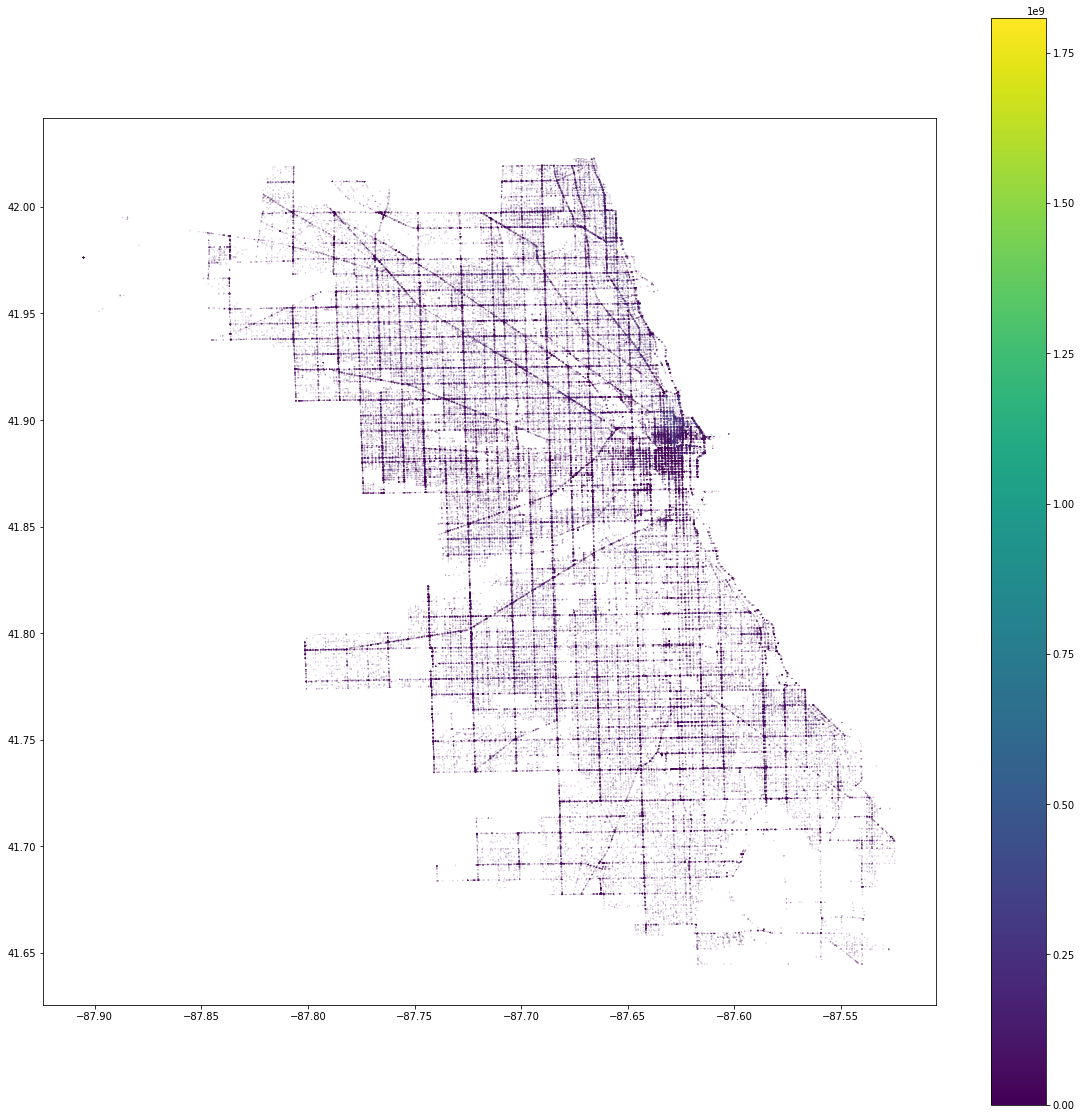

In [132]:
crash_joined_1.plot(column='pop_density', markersize=0.01,figsize=(20,20),legend=True)

In [86]:
crash_joined_1.shape

(195306, 64)

<a id='solar-position'></a>
### 3.4 Solar Position

<a id='weather'></a>
### 3.5 Weather

## Data Analysis

### An overview of geographic distribution
What does the 239k traffic crashes look like?

Text(0.5, 1.0, 'Crash in Chicago from 2016 to 2018')

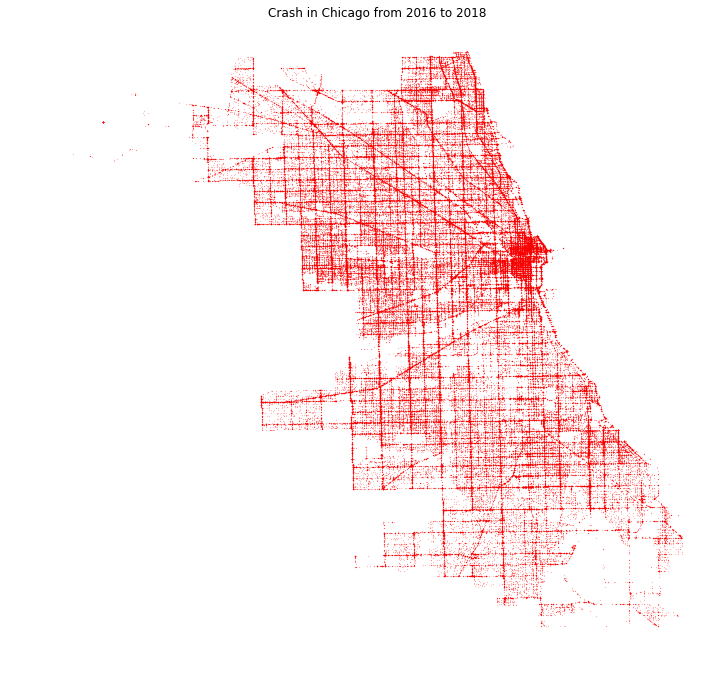

In [110]:
crash.plot(markersize=0.01, edgecolor='red',figsize=(12,12));
plt.axis('off');
plt.title('Crash in Chicago from 2016 to 2018')

In [9]:
"""crash.info()
selected_clomuns = ['RD_NO','CRASH_DATE','POSTED_SPEED_LIMIT',
                    'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',
                    'ROAD_DEFECT','INTERSECTION_RELATED_I',
                    'STREET_NO','STREET_DIRECTION','STREET_NAME ',
                    'LATITUDE','LONGITUDE','LOCATION ',
                    'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH ',
                    'MOST_SEVERE_INJURY '
                   ]"""

"crash.info()\nselected_clomuns = ['RD_NO','CRASH_DATE','POSTED_SPEED_LIMIT',\n                    'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',\n                    'ROAD_DEFECT','INTERSECTION_RELATED_I',\n                    'STREET_NO','STREET_DIRECTION','STREET_NAME ',\n                    'LATITUDE','LONGITUDE','LOCATION ',\n                    'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH ',\n                    'MOST_SEVERE_INJURY '\n                   ]"

### Number of crashes by a single feature

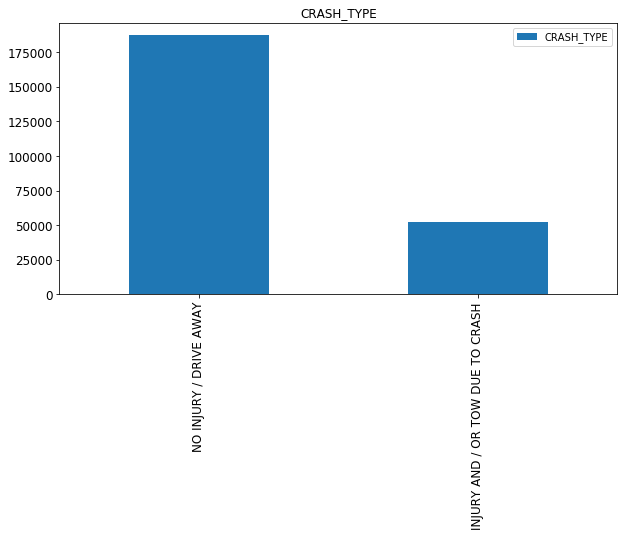

In [10]:
crash['CRASH_TYPE'].value_counts().plot(kind='bar', title ="CRASH_TYPE", figsize=(10, 5), legend=True, fontsize=12)

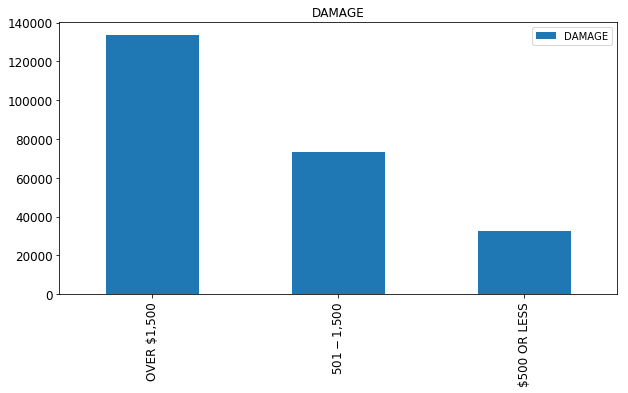

In [11]:
crash['DAMAGE'].value_counts().plot(kind='bar', title ="DAMAGE", figsize=(10, 5), legend=True, fontsize=12)

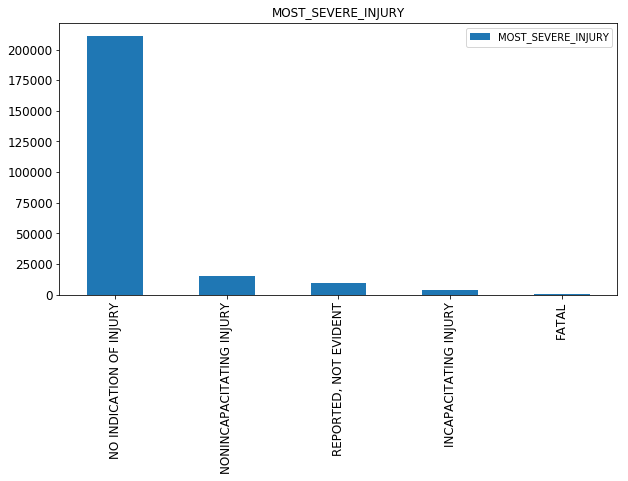

In [12]:
crash['MOST_SEVERE_INJURY'].value_counts().plot(kind='bar', title ="MOST_SEVERE_INJURY", figsize=(10, 5), legend=True, fontsize=12)

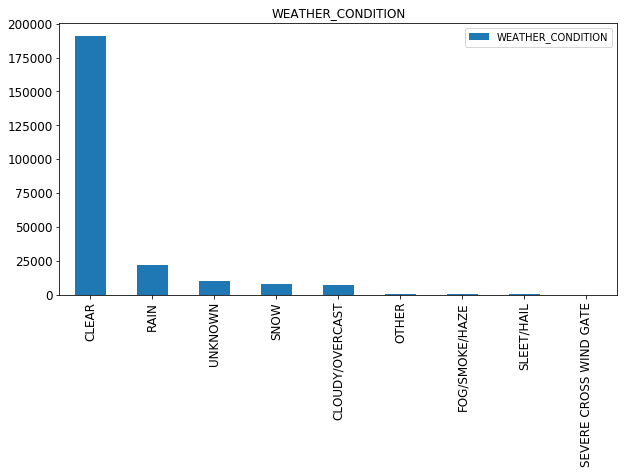

In [13]:
crash['WEATHER_CONDITION'].value_counts().plot(kind='bar', title ="WEATHER_CONDITION", figsize=(10, 5), legend=True, fontsize=12)

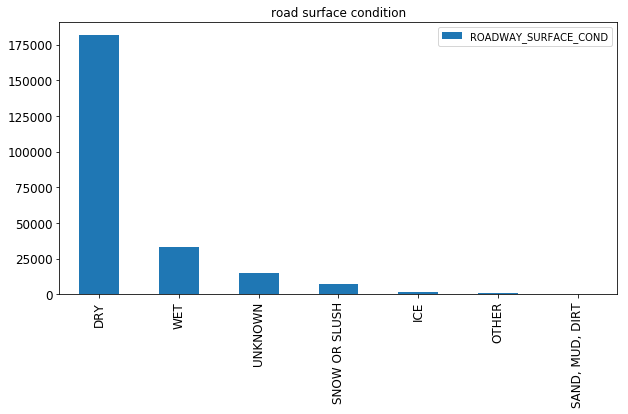

In [14]:
crash['ROADWAY_SURFACE_COND'].value_counts().plot(kind='bar', title ="road surface condition", figsize=(10, 5), legend=True, fontsize=12)

### Number of crashes by time-related varables

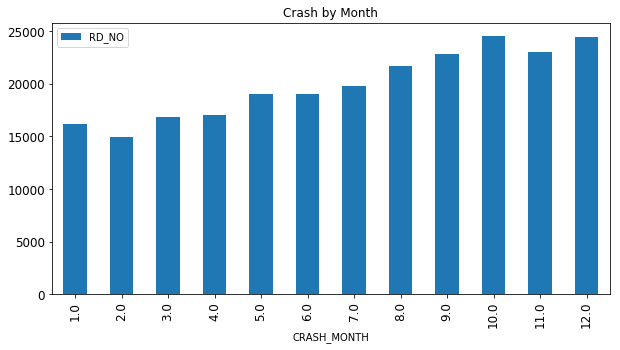

In [15]:
crash.groupby(['CRASH_MONTH']).count()['RD_NO'].plot(kind='bar', title ="Crash by Month", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in Sep to Oct, namely late autumn and early winter.

*Crashes by day of week (Sunday == 1)*

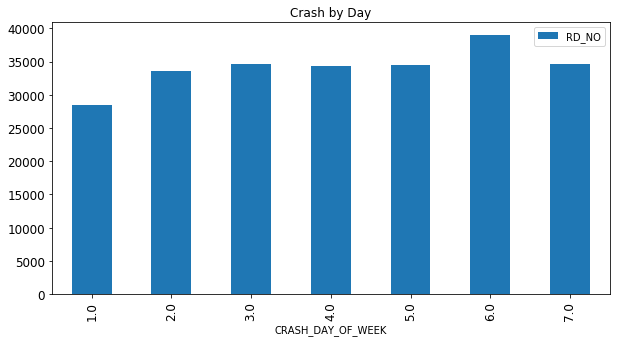

In [16]:
crash.groupby(['CRASH_DAY_OF_WEEK']).count()['RD_NO'].plot(kind='bar', title ="Crash by Day", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in Friday 

*Crashes by hours*

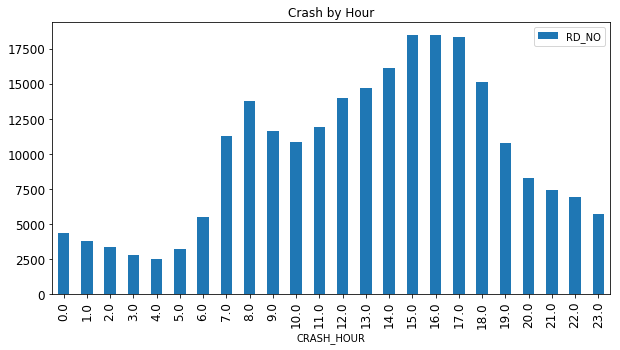

In [17]:
crash.groupby(['CRASH_HOUR']).count()['RD_NO'].plot(kind='bar', title ="Crash by Hour", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in rush hours 

<a id='folium-heatmap'></a>
### Number of crashes by location-realated variables

#### *NOTE: POSSIBILITY OF RENDERING FAILURE.*
#### The follwoing two figures are two dynamic heatmaps showing crashes distribution in 2018. In case that the figures may FAIL TO RENDER in Github repo, please visit [THIS LINK](https://nbviewer.jupyter.org/github/shengbo-ma/Prediction-of-Traffic-Crash-Risk-in-Chicago/blob/master/Chicago_Traffic_Crashes.ipynb#folium-heatmap) to see them.

*Dynamic Heapmap 1. Geographic distribution of crash by month in 2018*

In [18]:
map_chicago = folium.Map(location=[41.830994, -87.647345],
                         tiles = "Stamen Terrain",
                         zoom_start = 10) 

crash2018 = crash[(crash['CRASH_DATE'] < pd.datetime(2019,1,1)) & (crash['CRASH_DATE'] >= pd.datetime(2018,1,1))].copy()

heatmap = []
for i in range(1, 13):
    df = crash2018[crash2018['CRASH_MONTH'] == i]
    df1 = df.sample(int(len(df)*0.3))
    cood = [[row["LATITUDE"], row["LONGITUDE"]] for idx, row in df1.iterrows()]
    heatmap.append(cood)
    
plugins.HeatMapWithTime(heatmap, radius=3, auto_play=True,max_opacity=0.8).add_to(map_chicago)
map_chicago


*Dynamic Heapmap 2. Geographic distribution of crash by hour in 2018*

In [19]:
map_chicago = folium.Map(location=[41.830994, -87.647345],
                         tiles = "Stamen Terrain",
                         zoom_start = 10) 

crash2018 = crash[(crash['CRASH_DATE'] < pd.datetime(2019,1,1)) & (crash['CRASH_DATE'] >= pd.datetime(2018,1,1))].copy()

heatmap = []
for i in range(0,24):
    df = crash2018[crash2018['CRASH_HOUR'] == i]
    df1 = df.sample(int(len(df)*0.1))
    cood = [[row["LATITUDE"], row["LONGITUDE"]] for idx, row in df1.iterrows()]
    heatmap.append(cood)
    
plugins.HeatMapWithTime(heatmap, radius=5, auto_play=True,max_opacity=0.8).add_to(map_chicago)
map_chicago

In [20]:
#map_chicago.save('crash heatmap.html')

*number of crashes by street*

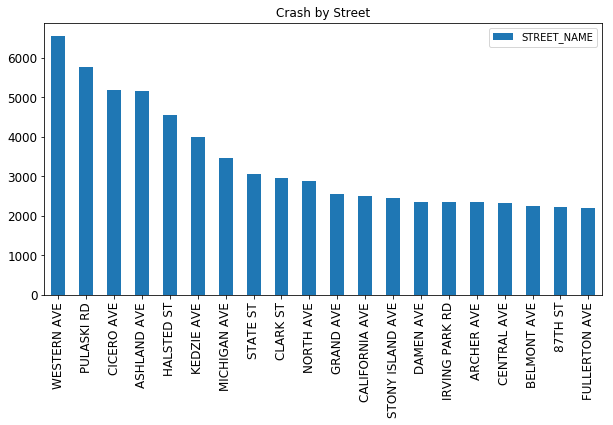

In [21]:
crash['STREET_NAME'].value_counts()[:min(20, len(crash))].plot(kind='bar', title ="Crash by Street", figsize=(10, 5), legend=True, fontsize=12)

<a id='modeling'></a>
# Modeling

In [22]:

features = ['POSTED_SPEED_LIMIT',
            'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',
            'ROAD_DEFECT',
            'STREET_NO','STREET_DIRECTION','STREET_NAME',
            'LATITUDE','LONGITUDE',
            'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH',
            'MOST_SEVERE_INJURY','DAMAGE','FIRST_CRASH_TYPE','TRAFFICWAY_TYPE',
            'INJURIES_FATAL', 'INJURIES_INCAPACITATING'
            ]


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

In [24]:
# Convert geo-dataframe into a regular dataframe.
df = pd.DataFrame(crash[features])
#df.head()
#ss_lat = StandardScaler()
#df['LATITUDE'] = ss_lat.fit_transform(df['LATITUDE'].values.reshape(-1,1)).flatten()
#ss_lon = StandardScaler()
#df['LONGITUDE'] = ss_lon.fit_transform(df['LONGITUDE'].values.reshape(-1,1)).flatten()

#df.shape
df.describe()


,POSTED_SPEED_LIMIT,STREET_NO,LATITUDE,LONGITUDE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,INJURIES_FATAL,INJURIES_INCAPACITATING
count,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000
mean,28.790876,3575.523670,41.861295,-87.677798,13.213233,4.121926,7.035310,0.000915,0.017402
std,5.369394,2802.665901,0.084772,0.057604,5.434908,1.965087,3.411727,0.033144,0.154232
min,5.000000,1.000000,41.644670,-87.925036,0.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,1199.000000,41.787749,-87.720186,9.000000,2.000000,4.000000,0.000000,0.000000
50%,30.000000,3100.000000,41.878310,-87.672286,14.000000,4.000000,7.000000,0.000000,0.000000
75%,30.000000,5500.000000,41.924977,-87.632788,17.000000,6.000000,10.000000,0.000000,0.000000
max,70.000000,13799.000000,42.022780,-87.524589,23.000000,7.000000,12.000000,3.000000,7.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239227 entries, 38726 to 285196
Data columns (total 20 columns):
POSTED_SPEED_LIMIT         239227 non-null float64
TRAFFIC_CONTROL_DEVICE     239227 non-null object
DEVICE_CONDITION           239227 non-null object
WEATHER_CONDITION          239227 non-null object
LIGHTING_CONDITION         239227 non-null object
ROAD_DEFECT                239227 non-null object
STREET_NO                  239227 non-null float64
STREET_DIRECTION           239227 non-null object
STREET_NAME                239227 non-null object
LATITUDE                   239227 non-null float64
LONGITUDE                  239227 non-null float64
CRASH_HOUR                 239227 non-null float64
CRASH_DAY_OF_WEEK          239227 non-null float64
CRASH_MONTH                239227 non-null float64
MOST_SEVERE_INJURY         239227 non-null object
DAMAGE                     239227 non-null object
FIRST_CRASH_TYPE           239227 non-null object
TRAFFICWAY_TYPE            2

In [26]:
"""
cols = ['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROAD_DEFECT', 
       'STREET_DIRECTION', 'STREET_NAME', 
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'
       ]

for i in range(len(cols)):
    print(cols[i])
    df[cols[i]].value_counts()
"""

"\ncols = ['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',\n       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROAD_DEFECT', \n       'STREET_DIRECTION', 'STREET_NAME', \n       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'\n       ]\n\nfor i in range(len(cols)):\n    print(cols[i])\n    df[cols[i]].value_counts()\n"

### Correlation coeeficients between features.

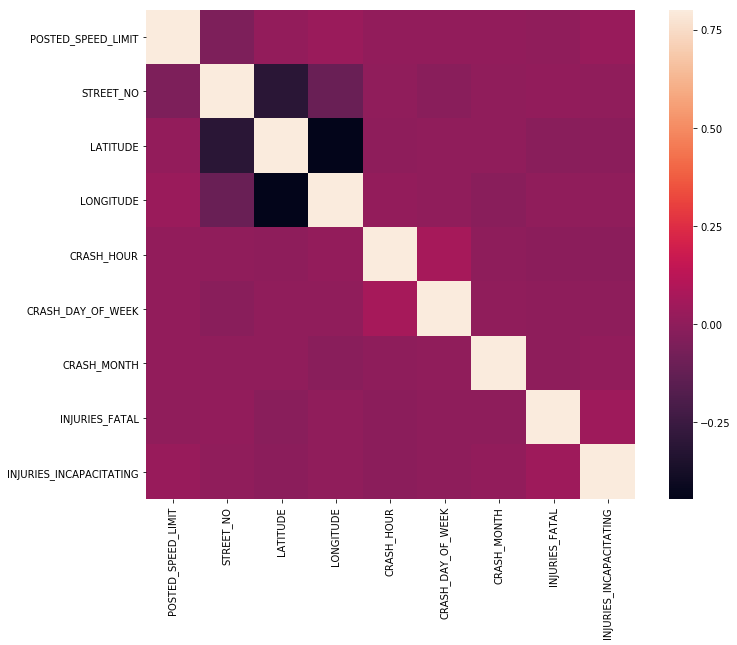

In [27]:
corr_mat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True)

### Encoding of labels

In [28]:
# Encoding catagory variables
from sklearn.preprocessing import LabelEncoder
lblE = LabelEncoder()
for i in df:
    if df[i].dtype == 'object':
        lblE.fit(df[i])
        df[i] = lblE.transform(df[i])
df = pd.get_dummies(df)
df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,ROAD_DEFECT,STREET_NO,STREET_DIRECTION,STREET_NAME,LATITUDE,LONGITUDE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,MOST_SEVERE_INJURY,DAMAGE,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,INJURIES_FATAL,INJURIES_INCAPACITATING
38726,30.0,12,1,8,1,5,3400.0,3,841,41.884754,-87.711230,23.0,2.0,12.0,2,0,14,5,0.0,0.0
38727,30.0,2,3,0,1,1,12901.0,2,740,41.660397,-87.618035,23.0,2.0,12.0,2,1,12,5,0.0,0.0
38728,35.0,2,3,0,1,1,699.0,2,835,41.873324,-87.616936,23.0,2.0,12.0,2,0,12,2,0.0,0.0
38729,30.0,2,3,8,5,1,4641.0,2,974,41.809188,-87.666049,23.0,2.0,12.0,2,2,7,5,0.0,0.0
38730,30.0,2,3,4,1,1,530.0,1,822,41.891682,-87.632731,23.0,2.0,12.0,2,2,10,5,0.0,0.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['INJURIES_FATAL', 'INJURIES_INCAPACITATING'], axis=1), 
                                                    df['INJURIES_FATAL'], test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160282, 18), (78945, 18), (160282,), (78945,))

In [30]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print ("\nRMSE for train set: ", res[0],
           "\nRMSE for test set: ", res[1],
           "\nScore for train set: ", res[2],
           "\nScore for test set: ", res[3]
          )

### Random Forrest Regression

In [31]:

rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, y_train)
print_score(rfr)


RMSE for train set:  0.003979270226112333 
RMSE for test set:  0.011025566360059398 
Score for train set:  0.9853183475922144 
Score for test set:  0.8932866428323727


In [32]:
f_imp = pd.DataFrame(data={'importance':rfr.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp

,importance
features,
MOST_SEVERE_INJURY,0.922133
STREET_NAME,0.012791
STREET_NO,0.012258
CRASH_HOUR,0.012220
TRAFFICWAY_TYPE,0.007203
FIRST_CRASH_TYPE,0.005789
CRASH_MONTH,0.004466
LONGITUDE,0.004257
CRASH_DAY_OF_WEEK,0.004214


Besides the non-surprising result that 'MOST_SEVERE_INJURY' is most related, we can see in the feature importance table that:
1. The street where the crash happened are more related to the number of death.
2. The hour and day of week are more related to the number of death, comparede to the month.
3. Weather and traffic control device seems not related to the number of death, which is not a straightforward result.

<a id='conclusion'></a>
# Conclusion

By analyzing the modeling the traffic crash data, we have successfully predict the severity of crashes based on Random Forrest Regression with a score of 0.89. Future works will be predicting the probobility of crashes per raod segment and per hour. 